In [1]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

def obtain_fda_results(api_key, drug_term):
    base_url = "https://api.fda.gov/drug/event.json"
    
    # Parámetros de búsqueda
    params = {
        'api_key': api_key,
        'search': f'"patient.drug.medicinalproduct.exact:""{drug_term}"',
        'count': "patient.reaction.reactionmeddrapt.exact"
        }

    headers = {
        'Content-Type': 'application/json',
    }

    try:
        # Realizar la llamada a la API
        response = requests.get(base_url,  params=params, headers=headers)
        response.raise_for_status()  # Verificar si hay errores en la respuesta HTTP

        # Convertir la respuesta a JSON
        data = response.json()

        # Verificar si 'results' está presente
        if 'results' in data:
            # Devolver el json resultante
            return data
        else:
            print(f"No se encontraron resultados para {drug_term}")
            return None
    
    except requests.exceptions.RequestException as e:
        print(f"Error en la llamada a la API para {drug_term}: {e}")

def obtain_fda_results_from_list(api_key, drugs):
    
    df_results = pd.DataFrame(columns=['farmaco', 'term', 'count'])

    for drug in drugs['Farmaco']:
        data = obtain_fda_results(api_key,drug)
        
        # Verificar si 'results' está presente en data
        if data is not None and 'results' in data:
            # Crear un DataFrame para los resultados del farmaco actual
            df_drug = pd.DataFrame(data['results'])
            df_drug['farmaco'] = drug
            
            # Concatenar al DataFrame principal
            df_results = pd.concat([df_results, df_drug], ignore_index=True)
        
        # Añadir un tiempo de espera de 1 segundo
        time.sleep(1)

    return df_results

In [2]:
#Funcion de preprocesado de datos

def data_preprocessing(results_df, rows = "farmaco", columns = "term", cellValues = "count", num_top_events = 12):
    #Preprocesamieto del dataframe

    # Utilizamos la función pivot_table (gestiona duplicados) para convertir el DataFrame largo a uno ancho
    results_df_wide = results_df.pivot_table(index=rows, columns=columns, values=cellValues)

    #Se elimina la etiqueta farmaco como nombre de columna
    results_df_wide.columns.name = None

    #Se resetea los indices para que Tipo de tumor y los nombres de los farmacos esten al mismo nivel
    results_df_wide.reset_index(inplace=True)

    #Se extraen los 25 eventos con mayor número de resultados en la bibliografía. Independientemente del tipo de tumor 
    top_events = results_df_wide.drop(columns=[rows]).sum().sort_values(ascending=False).head(num_top_events)

    #Filtra el dataframe para quedarte solo con la columna de tipo de tumor y los farmacos con más resultados
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]

    #Define el tipo de tumor como los indices del dataframe
    results_df_wide.set_index(rows, inplace=True)

    # Suma el total de resultados de los 15 fármacos para cada tipo de tumor y crea una nueva columna llamada 'TotalResultados'
    results_df_wide['TotalResultados'] = results_df_wide[list(top_events.index)].sum(axis=1)

    # Ordena el DataFrame por la nueva columna 'TotalResultados' en orden descendente
    results_df_wide = results_df_wide.sort_values(by='TotalResultados', ascending=False).reset_index()
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]
    results_df_wide.set_index(rows, inplace=True)

    results_df = results_df_wide.fillna(0)
    
    return results_df, top_events

def bar_plot_results(results_df_wide, top_events, num_columns = 25, xlab = 'Fármacos', 
                     plot_title ='Farmacos y efecto adverso. Source:Faers', legend_title = 'Efecto adverso'):
    # Visualizar los resultados de cada farmaco en función del tipo de tumor

    # Configura la paleta de colores única para cada fármaco con Seaborn
    colors = sns.color_palette("Set3", n_colors=len(top_events))

    # Creamos un gráfico de barras apiladas
    ax = results_df_wide.head(num_columns).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

    # Añadimos etiquetas y título
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel('Número de Resultados', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.legend(title= legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')  # Colocar la leyenda a la derecha
    plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
    plt.tight_layout()  # Ajustar el diseño del gráfico
    plt.show()

In [3]:
# Reemplaza 'tu_token_aqui' con tu token real
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drug_term = 'ipilimumab'

response= obtain_fda_results(token_api, drug_term)


In [3]:
with open('../results/output.json', 'w', encoding='utf-8') as f:
            json.dump(response, f, ensure_ascii=False, indent=2)

In [6]:
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drugs = pd.read_csv("../data/farmacos.csv", header = None, names = ['Farmaco'])

In [7]:
results = obtain_fda_results_from_list(token_api, drugs)
results

Error en la llamada a la API para emtansine trastuzumab: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22emtansine+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact
Error en la llamada a la API para deruxtecan trastuzumab: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22deruxtecan+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact


,farmaco,term,count
0,pembrolizumab,MALIGNANT NEOPLASM PROGRESSION,7917
1,pembrolizumab,DEATH,4111
2,pembrolizumab,DIARRHOEA,3462
3,pembrolizumab,FATIGUE,3389
4,pembrolizumab,OFF LABEL USE,3002
...,...,...,...
6195,sotorasib,LIVER FUNCTION TEST ABNORMAL,7
6196,sotorasib,METASTASES TO BONE,7
6197,sotorasib,MUSCLE SPASMS,7
6198,sotorasib,NEOPLASM MALIGNANT,7


In [20]:
#Salvar resultados de la búsqueda en pubmed en .csv
results.to_csv('resultados_faers.csv', index=False)

In [8]:
#Cargar datos de Faers 
results_df = pd.read_csv('../results/resultados_faers.csv')
results_df = results_df.fillna(0)

In [17]:
results_df

,farmaco,term,count
0,pembrolizumab,MALIGNANT NEOPLASM PROGRESSION,7917
1,pembrolizumab,DEATH,4111
2,pembrolizumab,DIARRHOEA,3462
3,pembrolizumab,FATIGUE,3389
4,pembrolizumab,OFF LABEL USE,3002
...,...,...,...
6195,sotorasib,LIVER FUNCTION TEST ABNORMAL,7
6196,sotorasib,METASTASES TO BONE,7
6197,sotorasib,MUSCLE SPASMS,7
6198,sotorasib,NEOPLASM MALIGNANT,7


In [19]:
adverse_effects = pd.read_csv("../example_data/efectos_adversos.csv")
retain_columns = list(adverse_effects[adverse_effects.columns[0]])
retain_columns

['dysphagia']

In [20]:
results_df[results_df['term'].str.lower().isin([adverse_effect.lower() for adverse_effect in retain_columns])]

,farmaco,term,count
79,pembrolizumab,DYSPHAGIA,425
158,osimertinib,DYSPHAGIA,112
283,nivolumab,DYSPHAGIA,493
385,abemaciclib,DYSPHAGIA,60
646,alectinib,DYSPHAGIA,56
733,dabrafenib,DYSPHAGIA,259
1063,cabozantinib,DYSPHAGIA,336
1171,ramucirumab,DYSPHAGIA,40
1291,atezolizumab,DYSPHAGIA,154
1460,olaparib,DYSPHAGIA,101


In [9]:
results_df_wide, top_farmacos = data_preprocessing(results_df)
results_df_wide

,DEATH,DIARRHOEA,OFF LABEL USE,FATIGUE,NAUSEA,VOMITING,MALIGNANT NEOPLASM PROGRESSION,PYREXIA,DYSPNOEA,NEUTROPENIA,ASTHENIA,DISEASE PROGRESSION
farmaco,,,,,,,,,,,,
sodium chloride,21163.0,8795.0,11703.0,9269.0,11438.0,10363.0,0.0,8754.0,10578.0,2339.0,6940.0,0.0
denosumab,18647.0,4416.0,35462.0,6479.0,4628.0,2244.0,1884.0,2118.0,3191.0,1385.0,3527.0,1156.0
bevacizumab,11827.0,6634.0,10033.0,5631.0,6119.0,4691.0,2329.0,3673.0,3252.0,3525.0,3256.0,6395.0
capecitabine,8679.0,13326.0,3243.0,6362.0,8241.0,6058.0,3384.0,2359.0,2552.0,2767.0,3189.0,5697.0
carboplatin,3833.0,5201.0,5968.0,4005.0,6181.0,4653.0,4826.0,4083.0,5016.0,6012.0,3070.0,4714.0
...,...,...,...,...,...,...,...,...,...,...,...,...
sotorasib,209.0,207.0,123.0,67.0,72.0,34.0,12.0,20.0,34.0,0.0,27.0,293.0
plerixafor,50.0,97.0,65.0,39.0,80.0,49.0,11.0,85.0,35.0,43.0,22.0,20.0
paclitaxel albumin,39.0,34.0,39.0,19.0,39.0,23.0,61.0,46.0,16.0,30.0,19.0,17.0


In [14]:
retain_columns = list(adverse_effects[adverse_effects.columns[0]])

results_df_wide[retain_columns]

KeyError: "None of [Index(['dysphagia'], dtype='object')] are in the [columns]"

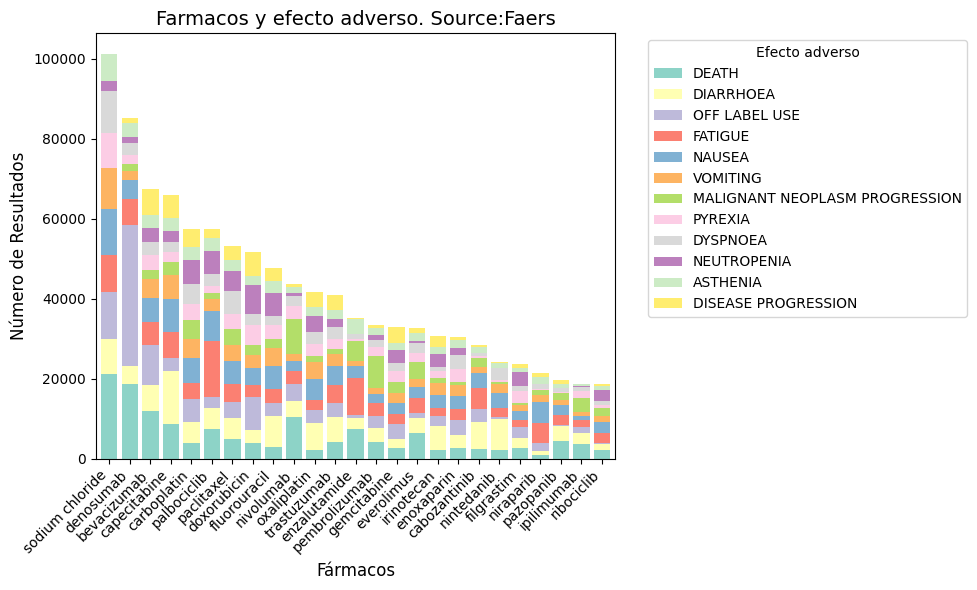

In [23]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor
bar_plot_results(results_df_wide, top_farmacos)